# _*Qiskit Finance: qGANs for Loading Random Distributions*_ 

Qiskit Finance is part of <a href="https://qiskit.org/aqua">Qiskit Aqua</a>.<br>
The latest version of this notebook is available on https://github.com/Qiskit/qiskit-tutorials.

***
### Contributors
Christa Zoufal<sup>[1,2]</sup>, Stefan Woerner<sup>[1]</sup>
### Affliation
- <sup>[1]</sup>IBMQ
- <sup>[2]</sup>ETH Zurich

### Introduction
Given $k$-dimensional data samples, we employ a quantum Generative Adversarial Network (qGAN) to learn the data's underlying random distribution and to load it directly into a quantum state: 
$$\lvert g_{\theta}\rangle = \sum\limits_{j=0}^{2^n-1}\sqrt{p_{\theta}^{j}}\lvert{j}\rangle$$
where $p_{\theta}^{j}$ describe the occurrence probabilities of the basis states $\vert j\rangle$. 

The aim of the qGAN training is to generate a state $\lvert g_{\theta}\rangle$ where $p_{\theta}^{j}$, for $j\in \left\{0, \ldots, {2^n-1} \right\}$, describe a probability distribution that is close to the distribution underlying the training data $X=\left\{x^0, \ldots, x^{k-1} \right\}$.

For further details please refer to https://arxiv.org/abs/1904.00043.

In [1]:
#!/usr/bin/env python
# coding: utf-8
from __future__ import absolute_import, division, print_function

import numpy as np

import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

%matplotlib inline


import time

start = time.time()

from torch import optim
from qiskit.aqua.algorithms.adaptive.qgan.discriminator import DiscriminatorNet

from qiskit.aqua.components.optimizers import ADAM
from qiskit.aqua.components.uncertainty_models import UniformDistribution, UnivariateVariationalDistribution 
from qiskit.aqua.components.variational_forms import RY

from qiskit.aqua.algorithms.adaptive.qgan.qgan import QGAN

from qiskit.aqua import aqua_globals, QuantumInstance

from qiskit.providers.ibmq import IBMQ
from qiskit import Aer

### Load the Training Data
First, we need to load the $k$-dimensional training data samples (here k=1). <br/>
Next, the data resolution is set, i.e. the min/max data values and the number of qubits used to represent each data dimension.

In [2]:
# Number training data samples
N = 10000 

# Load data samples from log-normal distribution with mean=1 and standard deviation=1
mu = 1
sigma = 1
real_data = np.random.lognormal(mean = mu, sigma=sigma, size=N)

# Set the data resolution
# Set upper and lower data values as list of k min/max data values [[min_0,max_0],...,[min_k-1,max_k-1]]
bounds = np.array([0.,3.]) 
# Set number of qubits per data dimension as list of k qubit values[#q_0,...,#q_k-1]
num_qubits = [2]
k = len(num_qubits)

### Initialize the qGAN
The qGAN consists of a quantum generator $G_{\theta}$, a variational quantum circuit, and a classical discriminator $D_{\phi}$, a neural network. <br/>
To implement the quantum generator, we choose a depth-$1$ variational form that implements $R_Y$ rotations and $CZ$ gates which takes a uniform distribution as an input state. Notably, for $k>1$ the generator's parameters must be chosen carefully. For example, the circuit depth should $>1$ becaue the higher the circuit depth the because higher circuit depths enable the representation of more complex structures.<br/>
The classical discriminator is given by a $3$-layer neural network that applies linear transformations, leaky ReLU functions in the hidden layers and a sigmoid function in the output layer. Notably, the neural network is implemented with PyTorch. Please refer to https://pytorch.org/get-started/locally/ for PyTorch installation instructions.<br/>
Here, both networks are updated with the ADAM optimization algorithm.

In [3]:
# Set number of training epochs
# Note: The algorithm's runtime can be shortened by reducing the number of training epochs.
num_epochs = 3000
# Batch size
batch_size = 1000

# Initialize qGAN
qgan = QGAN(real_data, bounds, num_qubits, batch_size, num_epochs, snapshot_dir=None)

# Set quantum instance to run the quantum generator
backend = Aer.get_backend('statevector_simulator')
qgan.set_quantum_instance(QuantumInstance(backend=backend, shots=batch_size, coupling_map=None, circuit_caching=False))


# Set entangler map
entangler_map = [[0, 1]]
        
# Set variational form
var_form = RY(int(np.sum(num_qubits)), depth=1, entangler_map=entangler_map, entanglement_gate='cz')
# Set generator's initial parameters
init_params = aqua_globals.random.rand(var_form._num_parameters) * 2 * 1e-2
# Set an initial state for the generator circuit
init_dist = UniformDistribution(np.sum(num_qubits), low=bounds[0], high=bounds[1])
# Set generator circuit
g_circuit = UnivariateVariationalDistribution(np.sum(num_qubits), var_form, init_params,
                                        initial_distribution=init_dist, low=bounds[0], high=bounds[1])
# Set generator optimizer
g_optimizer = ADAM(maxiter=1, tol=1e-6, lr=1e-5, beta_1=0.9, beta_2=0.99, noise_factor=1e-6,
                 eps=1e-10, amsgrad=True)
# Set quantum generator
qgan.set_generator(generator_circuit=g_circuit, generator_optimizer=g_optimizer)

# Set discriminator network
d_net = DiscriminatorNet(n_features=k)
# Set discriminator optimizer
d_optimizer = optim.Adam(d_net.parameters(), lr=1e-5, amsgrad=True)
# Set classical discriminator neural network
qgan.set_discriminator(discriminator_net=d_net, discriminator_optimizer=d_optimizer)

### Run the qGAN Training
During the training the discriminator's and the generator's parameters are updated alternately w.r.t the following loss functions:
$$ L_G\left(\phi, \theta\right) = -\frac{1}{m}\sum\limits_{l=1}^{m}\left[\log\left(D_{\phi}\left(g^{l}\right)\right)\right] $$
and
$$  L_D\left(\phi, \theta\right) =
	\frac{1}{m}\sum\limits_{l=1}^{m}\left[\log D_{\phi}\left(x^{l}\right) + \log\left(1-D_{\phi}\left(g^{l}\right)\right)\right], $$
with $m$ denoting the batch size and $g^l$ describing the data samples generated by the quantum generator.

In [4]:
# Run qGAN
qgan.run()

# Runtime
end = time.time()
print('qGAN training runtime: ', (end - start)/60., ' min')

Epoch 1/3000...
Loss Discriminator:  0.6973
Loss Generator:  0.6708
Relative Entropy:  0.1718
Epoch 2/3000...
Loss Discriminator:  0.6962
Loss Generator:  0.679
Relative Entropy:  0.1719
Epoch 3/3000...
Loss Discriminator:  0.6948
Loss Generator:  0.6824
Relative Entropy:  0.172
Epoch 4/3000...
Loss Discriminator:  0.6934
Loss Generator:  0.6843
Relative Entropy:  0.172
Epoch 5/3000...
Loss Discriminator:  0.692
Loss Generator:  0.6861
Relative Entropy:  0.1719
Epoch 6/3000...
Loss Discriminator:  0.6909
Loss Generator:  0.6863
Relative Entropy:  0.1719
Epoch 7/3000...
Loss Discriminator:  0.6896
Loss Generator:  0.6854
Relative Entropy:  0.1718
Epoch 8/3000...
Loss Discriminator:  0.689
Loss Generator:  0.6867
Relative Entropy:  0.1718
Epoch 9/3000...
Loss Discriminator:  0.6882
Loss Generator:  0.6898
Relative Entropy:  0.1717
Epoch 10/3000...
Loss Discriminator:  0.6871
Loss Generator:  0.6905
Relative Entropy:  0.1717
Epoch 11/3000...
Loss Discriminator:  0.6865
Loss Generator:  0.

Loss Discriminator:  0.6687
Loss Generator:  0.7357
Relative Entropy:  0.1663
Epoch 89/3000...
Loss Discriminator:  0.6698
Loss Generator:  0.7339
Relative Entropy:  0.1662
Epoch 90/3000...
Loss Discriminator:  0.6699
Loss Generator:  0.7362
Relative Entropy:  0.1662
Epoch 91/3000...
Loss Discriminator:  0.6723
Loss Generator:  0.7372
Relative Entropy:  0.1661
Epoch 92/3000...
Loss Discriminator:  0.6688
Loss Generator:  0.7384
Relative Entropy:  0.166
Epoch 93/3000...
Loss Discriminator:  0.6701
Loss Generator:  0.7373
Relative Entropy:  0.166
Epoch 94/3000...
Loss Discriminator:  0.6664
Loss Generator:  0.7341
Relative Entropy:  0.1659
Epoch 95/3000...
Loss Discriminator:  0.6703
Loss Generator:  0.7329
Relative Entropy:  0.1658
Epoch 96/3000...
Loss Discriminator:  0.6705
Loss Generator:  0.7359
Relative Entropy:  0.1658
Epoch 97/3000...
Loss Discriminator:  0.6686
Loss Generator:  0.7376
Relative Entropy:  0.1657
Epoch 98/3000...
Loss Discriminator:  0.6724
Loss Generator:  0.7353


Loss Discriminator:  0.6683
Loss Generator:  0.7372
Relative Entropy:  0.1605
Epoch 175/3000...
Loss Discriminator:  0.669
Loss Generator:  0.7341
Relative Entropy:  0.1604
Epoch 176/3000...
Loss Discriminator:  0.6707
Loss Generator:  0.734
Relative Entropy:  0.1604
Epoch 177/3000...
Loss Discriminator:  0.6708
Loss Generator:  0.7374
Relative Entropy:  0.1603
Epoch 178/3000...
Loss Discriminator:  0.6724
Loss Generator:  0.7344
Relative Entropy:  0.1602
Epoch 179/3000...
Loss Discriminator:  0.6677
Loss Generator:  0.7357
Relative Entropy:  0.1602
Epoch 180/3000...
Loss Discriminator:  0.6695
Loss Generator:  0.7336
Relative Entropy:  0.1601
Epoch 181/3000...
Loss Discriminator:  0.6716
Loss Generator:  0.7365
Relative Entropy:  0.16
Epoch 182/3000...
Loss Discriminator:  0.6703
Loss Generator:  0.7338
Relative Entropy:  0.16
Epoch 183/3000...
Loss Discriminator:  0.6711
Loss Generator:  0.7355
Relative Entropy:  0.1599
Epoch 184/3000...
Loss Discriminator:  0.6679
Loss Generator:  0

Loss Discriminator:  0.6706
Loss Generator:  0.7331
Relative Entropy:  0.1549
Epoch 261/3000...
Loss Discriminator:  0.6708
Loss Generator:  0.7322
Relative Entropy:  0.1548
Epoch 262/3000...
Loss Discriminator:  0.6704
Loss Generator:  0.7358
Relative Entropy:  0.1547
Epoch 263/3000...
Loss Discriminator:  0.6721
Loss Generator:  0.7342
Relative Entropy:  0.1547
Epoch 264/3000...
Loss Discriminator:  0.6686
Loss Generator:  0.7317
Relative Entropy:  0.1546
Epoch 265/3000...
Loss Discriminator:  0.6708
Loss Generator:  0.7324
Relative Entropy:  0.1545
Epoch 266/3000...
Loss Discriminator:  0.6703
Loss Generator:  0.7328
Relative Entropy:  0.1545
Epoch 267/3000...
Loss Discriminator:  0.6692
Loss Generator:  0.7355
Relative Entropy:  0.1544
Epoch 268/3000...
Loss Discriminator:  0.6716
Loss Generator:  0.7314
Relative Entropy:  0.1543
Epoch 269/3000...
Loss Discriminator:  0.6724
Loss Generator:  0.7326
Relative Entropy:  0.1543
Epoch 270/3000...
Loss Discriminator:  0.6697
Loss Generat

Loss Discriminator:  0.6738
Loss Generator:  0.7345
Relative Entropy:  0.1493
Epoch 347/3000...
Loss Discriminator:  0.6705
Loss Generator:  0.7302
Relative Entropy:  0.1493
Epoch 348/3000...
Loss Discriminator:  0.6708
Loss Generator:  0.7294
Relative Entropy:  0.1492
Epoch 349/3000...
Loss Discriminator:  0.6719
Loss Generator:  0.73
Relative Entropy:  0.1492
Epoch 350/3000...
Loss Discriminator:  0.6691
Loss Generator:  0.7313
Relative Entropy:  0.1491
Epoch 351/3000...
Loss Discriminator:  0.6706
Loss Generator:  0.732
Relative Entropy:  0.149
Epoch 352/3000...
Loss Discriminator:  0.6717
Loss Generator:  0.7314
Relative Entropy:  0.149
Epoch 353/3000...
Loss Discriminator:  0.6715
Loss Generator:  0.7302
Relative Entropy:  0.1489
Epoch 354/3000...
Loss Discriminator:  0.6747
Loss Generator:  0.7306
Relative Entropy:  0.1488
Epoch 355/3000...
Loss Discriminator:  0.6719
Loss Generator:  0.7317
Relative Entropy:  0.1488
Epoch 356/3000...
Loss Discriminator:  0.6688
Loss Generator:  

Loss Discriminator:  0.6715
Loss Generator:  0.7289
Relative Entropy:  0.144
Epoch 433/3000...
Loss Discriminator:  0.6712
Loss Generator:  0.7311
Relative Entropy:  0.1439
Epoch 434/3000...
Loss Discriminator:  0.6705
Loss Generator:  0.7286
Relative Entropy:  0.1439
Epoch 435/3000...
Loss Discriminator:  0.6716
Loss Generator:  0.7286
Relative Entropy:  0.1438
Epoch 436/3000...
Loss Discriminator:  0.6703
Loss Generator:  0.7279
Relative Entropy:  0.1437
Epoch 437/3000...
Loss Discriminator:  0.6708
Loss Generator:  0.7327
Relative Entropy:  0.1437
Epoch 438/3000...
Loss Discriminator:  0.6724
Loss Generator:  0.7351
Relative Entropy:  0.1436
Epoch 439/3000...
Loss Discriminator:  0.6718
Loss Generator:  0.7277
Relative Entropy:  0.1436
Epoch 440/3000...
Loss Discriminator:  0.6722
Loss Generator:  0.7279
Relative Entropy:  0.1435
Epoch 441/3000...
Loss Discriminator:  0.6708
Loss Generator:  0.7299
Relative Entropy:  0.1434
Epoch 442/3000...
Loss Discriminator:  0.6734
Loss Generato

Loss Discriminator:  0.6741
Loss Generator:  0.7246
Relative Entropy:  0.1388
Epoch 519/3000...
Loss Discriminator:  0.6724
Loss Generator:  0.7276
Relative Entropy:  0.1387
Epoch 520/3000...
Loss Discriminator:  0.6698
Loss Generator:  0.7331
Relative Entropy:  0.1386
Epoch 521/3000...
Loss Discriminator:  0.6726
Loss Generator:  0.7287
Relative Entropy:  0.1386
Epoch 522/3000...
Loss Discriminator:  0.6727
Loss Generator:  0.7259
Relative Entropy:  0.1385
Epoch 523/3000...
Loss Discriminator:  0.6724
Loss Generator:  0.7291
Relative Entropy:  0.1385
Epoch 524/3000...
Loss Discriminator:  0.6702
Loss Generator:  0.7286
Relative Entropy:  0.1384
Epoch 525/3000...
Loss Discriminator:  0.6709
Loss Generator:  0.7284
Relative Entropy:  0.1383
Epoch 526/3000...
Loss Discriminator:  0.6732
Loss Generator:  0.7289
Relative Entropy:  0.1383
Epoch 527/3000...
Loss Discriminator:  0.6725
Loss Generator:  0.7278
Relative Entropy:  0.1382
Epoch 528/3000...
Loss Discriminator:  0.6724
Loss Generat

Loss Discriminator:  0.6717
Loss Generator:  0.7269
Relative Entropy:  0.1337
Epoch 605/3000...
Loss Discriminator:  0.6738
Loss Generator:  0.728
Relative Entropy:  0.1336
Epoch 606/3000...
Loss Discriminator:  0.6742
Loss Generator:  0.7296
Relative Entropy:  0.1336
Epoch 607/3000...
Loss Discriminator:  0.6727
Loss Generator:  0.7241
Relative Entropy:  0.1335
Epoch 608/3000...
Loss Discriminator:  0.6745
Loss Generator:  0.7251
Relative Entropy:  0.1334
Epoch 609/3000...
Loss Discriminator:  0.675
Loss Generator:  0.7259
Relative Entropy:  0.1334
Epoch 610/3000...
Loss Discriminator:  0.6724
Loss Generator:  0.7287
Relative Entropy:  0.1333
Epoch 611/3000...
Loss Discriminator:  0.6722
Loss Generator:  0.7243
Relative Entropy:  0.1333
Epoch 612/3000...
Loss Discriminator:  0.675
Loss Generator:  0.7268
Relative Entropy:  0.1332
Epoch 613/3000...
Loss Discriminator:  0.6741
Loss Generator:  0.7296
Relative Entropy:  0.1331
Epoch 614/3000...
Loss Discriminator:  0.6767
Loss Generator:

Loss Discriminator:  0.6741
Loss Generator:  0.7231
Relative Entropy:  0.1287
Epoch 691/3000...
Loss Discriminator:  0.6726
Loss Generator:  0.7253
Relative Entropy:  0.1287
Epoch 692/3000...
Loss Discriminator:  0.6737
Loss Generator:  0.7257
Relative Entropy:  0.1286
Epoch 693/3000...
Loss Discriminator:  0.6753
Loss Generator:  0.7225
Relative Entropy:  0.1286
Epoch 694/3000...
Loss Discriminator:  0.6752
Loss Generator:  0.7228
Relative Entropy:  0.1285
Epoch 695/3000...
Loss Discriminator:  0.6717
Loss Generator:  0.7268
Relative Entropy:  0.1284
Epoch 696/3000...
Loss Discriminator:  0.6746
Loss Generator:  0.7253
Relative Entropy:  0.1284
Epoch 697/3000...
Loss Discriminator:  0.6737
Loss Generator:  0.7251
Relative Entropy:  0.1283
Epoch 698/3000...
Loss Discriminator:  0.6764
Loss Generator:  0.7265
Relative Entropy:  0.1283
Epoch 699/3000...
Loss Discriminator:  0.6738
Loss Generator:  0.7271
Relative Entropy:  0.1282
Epoch 700/3000...
Loss Discriminator:  0.6753
Loss Generat

Loss Discriminator:  0.6757
Loss Generator:  0.7228
Relative Entropy:  0.1239
Epoch 777/3000...
Loss Discriminator:  0.677
Loss Generator:  0.7236
Relative Entropy:  0.1239
Epoch 778/3000...
Loss Discriminator:  0.6743
Loss Generator:  0.7271
Relative Entropy:  0.1238
Epoch 779/3000...
Loss Discriminator:  0.6743
Loss Generator:  0.7239
Relative Entropy:  0.1238
Epoch 780/3000...
Loss Discriminator:  0.6773
Loss Generator:  0.7215
Relative Entropy:  0.1237
Epoch 781/3000...
Loss Discriminator:  0.674
Loss Generator:  0.7211
Relative Entropy:  0.1236
Epoch 782/3000...
Loss Discriminator:  0.6765
Loss Generator:  0.725
Relative Entropy:  0.1236
Epoch 783/3000...
Loss Discriminator:  0.6771
Loss Generator:  0.7235
Relative Entropy:  0.1235
Epoch 784/3000...
Loss Discriminator:  0.6735
Loss Generator:  0.7228
Relative Entropy:  0.1235
Epoch 785/3000...
Loss Discriminator:  0.6738
Loss Generator:  0.7246
Relative Entropy:  0.1234
Epoch 786/3000...
Loss Discriminator:  0.6758
Loss Generator:

Loss Discriminator:  0.6768
Loss Generator:  0.7217
Relative Entropy:  0.1192
Epoch 863/3000...
Loss Discriminator:  0.6772
Loss Generator:  0.7229
Relative Entropy:  0.1192
Epoch 864/3000...
Loss Discriminator:  0.6751
Loss Generator:  0.7208
Relative Entropy:  0.1191
Epoch 865/3000...
Loss Discriminator:  0.675
Loss Generator:  0.7234
Relative Entropy:  0.1191
Epoch 866/3000...
Loss Discriminator:  0.6747
Loss Generator:  0.7212
Relative Entropy:  0.119
Epoch 867/3000...
Loss Discriminator:  0.6762
Loss Generator:  0.7229
Relative Entropy:  0.119
Epoch 868/3000...
Loss Discriminator:  0.6742
Loss Generator:  0.7211
Relative Entropy:  0.1189
Epoch 869/3000...
Loss Discriminator:  0.6765
Loss Generator:  0.7233
Relative Entropy:  0.1189
Epoch 870/3000...
Loss Discriminator:  0.6766
Loss Generator:  0.7221
Relative Entropy:  0.1188
Epoch 871/3000...
Loss Discriminator:  0.6766
Loss Generator:  0.7231
Relative Entropy:  0.1188
Epoch 872/3000...
Loss Discriminator:  0.6769
Loss Generator:

Loss Discriminator:  0.6757
Loss Generator:  0.7181
Relative Entropy:  0.1147
Epoch 949/3000...
Loss Discriminator:  0.676
Loss Generator:  0.7173
Relative Entropy:  0.1147
Epoch 950/3000...
Loss Discriminator:  0.6746
Loss Generator:  0.7237
Relative Entropy:  0.1146
Epoch 951/3000...
Loss Discriminator:  0.6755
Loss Generator:  0.7239
Relative Entropy:  0.1146
Epoch 952/3000...
Loss Discriminator:  0.6765
Loss Generator:  0.7189
Relative Entropy:  0.1145
Epoch 953/3000...
Loss Discriminator:  0.6761
Loss Generator:  0.7199
Relative Entropy:  0.1145
Epoch 954/3000...
Loss Discriminator:  0.6752
Loss Generator:  0.7205
Relative Entropy:  0.1144
Epoch 955/3000...
Loss Discriminator:  0.6768
Loss Generator:  0.7222
Relative Entropy:  0.1144
Epoch 956/3000...
Loss Discriminator:  0.6774
Loss Generator:  0.7207
Relative Entropy:  0.1143
Epoch 957/3000...
Loss Discriminator:  0.6791
Loss Generator:  0.7196
Relative Entropy:  0.1142
Epoch 958/3000...
Loss Discriminator:  0.6782
Loss Generato

Loss Discriminator:  0.6775
Loss Generator:  0.7203
Relative Entropy:  0.1103
Epoch 1035/3000...
Loss Discriminator:  0.6785
Loss Generator:  0.7233
Relative Entropy:  0.1103
Epoch 1036/3000...
Loss Discriminator:  0.6776
Loss Generator:  0.7173
Relative Entropy:  0.1102
Epoch 1037/3000...
Loss Discriminator:  0.6771
Loss Generator:  0.7182
Relative Entropy:  0.1102
Epoch 1038/3000...
Loss Discriminator:  0.6768
Loss Generator:  0.7197
Relative Entropy:  0.1101
Epoch 1039/3000...
Loss Discriminator:  0.6763
Loss Generator:  0.7179
Relative Entropy:  0.1101
Epoch 1040/3000...
Loss Discriminator:  0.6775
Loss Generator:  0.7187
Relative Entropy:  0.11
Epoch 1041/3000...
Loss Discriminator:  0.6771
Loss Generator:  0.7221
Relative Entropy:  0.11
Epoch 1042/3000...
Loss Discriminator:  0.6779
Loss Generator:  0.7199
Relative Entropy:  0.1099
Epoch 1043/3000...
Loss Discriminator:  0.6769
Loss Generator:  0.7207
Relative Entropy:  0.1099
Epoch 1044/3000...
Loss Discriminator:  0.6779
Loss G

Loss Discriminator:  0.6792
Loss Generator:  0.7194
Relative Entropy:  0.1061
Epoch 1120/3000...
Loss Discriminator:  0.6785
Loss Generator:  0.7196
Relative Entropy:  0.1061
Epoch 1121/3000...
Loss Discriminator:  0.6777
Loss Generator:  0.7171
Relative Entropy:  0.106
Epoch 1122/3000...
Loss Discriminator:  0.6766
Loss Generator:  0.7157
Relative Entropy:  0.106
Epoch 1123/3000...
Loss Discriminator:  0.6762
Loss Generator:  0.7177
Relative Entropy:  0.1059
Epoch 1124/3000...
Loss Discriminator:  0.6786
Loss Generator:  0.7183
Relative Entropy:  0.1059
Epoch 1125/3000...
Loss Discriminator:  0.6771
Loss Generator:  0.7193
Relative Entropy:  0.1058
Epoch 1126/3000...
Loss Discriminator:  0.6789
Loss Generator:  0.7162
Relative Entropy:  0.1058
Epoch 1127/3000...
Loss Discriminator:  0.6777
Loss Generator:  0.7194
Relative Entropy:  0.1057
Epoch 1128/3000...
Loss Discriminator:  0.6783
Loss Generator:  0.7172
Relative Entropy:  0.1057
Epoch 1129/3000...
Loss Discriminator:  0.6789
Loss

Loss Discriminator:  0.6788
Loss Generator:  0.7168
Relative Entropy:  0.102
Epoch 1205/3000...
Loss Discriminator:  0.6782
Loss Generator:  0.7177
Relative Entropy:  0.102
Epoch 1206/3000...
Loss Discriminator:  0.6793
Loss Generator:  0.7153
Relative Entropy:  0.1019
Epoch 1207/3000...
Loss Discriminator:  0.6785
Loss Generator:  0.7177
Relative Entropy:  0.1019
Epoch 1208/3000...
Loss Discriminator:  0.6794
Loss Generator:  0.7182
Relative Entropy:  0.1018
Epoch 1209/3000...
Loss Discriminator:  0.6782
Loss Generator:  0.717
Relative Entropy:  0.1018
Epoch 1210/3000...
Loss Discriminator:  0.6763
Loss Generator:  0.7193
Relative Entropy:  0.1018
Epoch 1211/3000...
Loss Discriminator:  0.6762
Loss Generator:  0.7169
Relative Entropy:  0.1017
Epoch 1212/3000...
Loss Discriminator:  0.6791
Loss Generator:  0.7168
Relative Entropy:  0.1017
Epoch 1213/3000...
Loss Discriminator:  0.6788
Loss Generator:  0.7168
Relative Entropy:  0.1016
Epoch 1214/3000...
Loss Discriminator:  0.677
Loss G

Loss Discriminator:  0.6814
Loss Generator:  0.7169
Relative Entropy:  0.0981
Epoch 1290/3000...
Loss Discriminator:  0.68
Loss Generator:  0.7155
Relative Entropy:  0.098
Epoch 1291/3000...
Loss Discriminator:  0.6784
Loss Generator:  0.7135
Relative Entropy:  0.098
Epoch 1292/3000...
Loss Discriminator:  0.6809
Loss Generator:  0.7157
Relative Entropy:  0.098
Epoch 1293/3000...
Loss Discriminator:  0.6798
Loss Generator:  0.7168
Relative Entropy:  0.0979
Epoch 1294/3000...
Loss Discriminator:  0.6793
Loss Generator:  0.717
Relative Entropy:  0.0979
Epoch 1295/3000...
Loss Discriminator:  0.6772
Loss Generator:  0.7172
Relative Entropy:  0.0978
Epoch 1296/3000...
Loss Discriminator:  0.6798
Loss Generator:  0.7152
Relative Entropy:  0.0978
Epoch 1297/3000...
Loss Discriminator:  0.68
Loss Generator:  0.7137
Relative Entropy:  0.0977
Epoch 1298/3000...
Loss Discriminator:  0.6807
Loss Generator:  0.7159
Relative Entropy:  0.0977
Epoch 1299/3000...
Loss Discriminator:  0.679
Loss Genera

Loss Discriminator:  0.6795
Loss Generator:  0.7137
Relative Entropy:  0.0943
Epoch 1375/3000...
Loss Discriminator:  0.6787
Loss Generator:  0.7135
Relative Entropy:  0.0942
Epoch 1376/3000...
Loss Discriminator:  0.6795
Loss Generator:  0.7162
Relative Entropy:  0.0942
Epoch 1377/3000...
Loss Discriminator:  0.6791
Loss Generator:  0.7164
Relative Entropy:  0.0941
Epoch 1378/3000...
Loss Discriminator:  0.6792
Loss Generator:  0.7141
Relative Entropy:  0.0941
Epoch 1379/3000...
Loss Discriminator:  0.6796
Loss Generator:  0.7133
Relative Entropy:  0.0941
Epoch 1380/3000...
Loss Discriminator:  0.6783
Loss Generator:  0.714
Relative Entropy:  0.094
Epoch 1381/3000...
Loss Discriminator:  0.6781
Loss Generator:  0.7151
Relative Entropy:  0.094
Epoch 1382/3000...
Loss Discriminator:  0.6802
Loss Generator:  0.7177
Relative Entropy:  0.0939
Epoch 1383/3000...
Loss Discriminator:  0.6789
Loss Generator:  0.7166
Relative Entropy:  0.0939
Epoch 1384/3000...
Loss Discriminator:  0.6798
Loss 

Loss Discriminator:  0.6806
Loss Generator:  0.7142
Relative Entropy:  0.0904
Epoch 1460/3000...
Loss Discriminator:  0.68
Loss Generator:  0.7136
Relative Entropy:  0.0904
Epoch 1461/3000...
Loss Discriminator:  0.6799
Loss Generator:  0.7124
Relative Entropy:  0.0903
Epoch 1462/3000...
Loss Discriminator:  0.6827
Loss Generator:  0.7138
Relative Entropy:  0.0903
Epoch 1463/3000...
Loss Discriminator:  0.679
Loss Generator:  0.7144
Relative Entropy:  0.0902
Epoch 1464/3000...
Loss Discriminator:  0.6798
Loss Generator:  0.7145
Relative Entropy:  0.0902
Epoch 1465/3000...
Loss Discriminator:  0.6806
Loss Generator:  0.7123
Relative Entropy:  0.0901
Epoch 1466/3000...
Loss Discriminator:  0.6814
Loss Generator:  0.7124
Relative Entropy:  0.0901
Epoch 1467/3000...
Loss Discriminator:  0.6811
Loss Generator:  0.7166
Relative Entropy:  0.0901
Epoch 1468/3000...
Loss Discriminator:  0.6802
Loss Generator:  0.7146
Relative Entropy:  0.09
Epoch 1469/3000...
Loss Discriminator:  0.6802
Loss Ge

Loss Discriminator:  0.6824
Loss Generator:  0.7138
Relative Entropy:  0.0865
Epoch 1545/3000...
Loss Discriminator:  0.6798
Loss Generator:  0.7107
Relative Entropy:  0.0865
Epoch 1546/3000...
Loss Discriminator:  0.6837
Loss Generator:  0.7134
Relative Entropy:  0.0864
Epoch 1547/3000...
Loss Discriminator:  0.6815
Loss Generator:  0.7159
Relative Entropy:  0.0864
Epoch 1548/3000...
Loss Discriminator:  0.6809
Loss Generator:  0.7104
Relative Entropy:  0.0863
Epoch 1549/3000...
Loss Discriminator:  0.6805
Loss Generator:  0.7099
Relative Entropy:  0.0863
Epoch 1550/3000...
Loss Discriminator:  0.6798
Loss Generator:  0.7127
Relative Entropy:  0.0862
Epoch 1551/3000...
Loss Discriminator:  0.6806
Loss Generator:  0.7146
Relative Entropy:  0.0862
Epoch 1552/3000...
Loss Discriminator:  0.6809
Loss Generator:  0.7146
Relative Entropy:  0.0861
Epoch 1553/3000...
Loss Discriminator:  0.6794
Loss Generator:  0.7113
Relative Entropy:  0.0861
Epoch 1554/3000...
Loss Discriminator:  0.6802
Lo

Loss Discriminator:  0.6798
Loss Generator:  0.7123
Relative Entropy:  0.0826
Epoch 1630/3000...
Loss Discriminator:  0.6808
Loss Generator:  0.7123
Relative Entropy:  0.0825
Epoch 1631/3000...
Loss Discriminator:  0.6798
Loss Generator:  0.7109
Relative Entropy:  0.0825
Epoch 1632/3000...
Loss Discriminator:  0.6807
Loss Generator:  0.7112
Relative Entropy:  0.0825
Epoch 1633/3000...
Loss Discriminator:  0.6827
Loss Generator:  0.7128
Relative Entropy:  0.0824
Epoch 1634/3000...
Loss Discriminator:  0.6839
Loss Generator:  0.7123
Relative Entropy:  0.0824
Epoch 1635/3000...
Loss Discriminator:  0.68
Loss Generator:  0.7124
Relative Entropy:  0.0823
Epoch 1636/3000...
Loss Discriminator:  0.6802
Loss Generator:  0.7097
Relative Entropy:  0.0823
Epoch 1637/3000...
Loss Discriminator:  0.6804
Loss Generator:  0.7113
Relative Entropy:  0.0822
Epoch 1638/3000...
Loss Discriminator:  0.68
Loss Generator:  0.7139
Relative Entropy:  0.0822
Epoch 1639/3000...
Loss Discriminator:  0.6804
Loss G

Loss Discriminator:  0.6813
Loss Generator:  0.7108
Relative Entropy:  0.0787
Epoch 1715/3000...
Loss Discriminator:  0.6821
Loss Generator:  0.7094
Relative Entropy:  0.0787
Epoch 1716/3000...
Loss Discriminator:  0.6812
Loss Generator:  0.7111
Relative Entropy:  0.0787
Epoch 1717/3000...
Loss Discriminator:  0.6827
Loss Generator:  0.7101
Relative Entropy:  0.0786
Epoch 1718/3000...
Loss Discriminator:  0.6812
Loss Generator:  0.7095
Relative Entropy:  0.0786
Epoch 1719/3000...
Loss Discriminator:  0.682
Loss Generator:  0.7093
Relative Entropy:  0.0785
Epoch 1720/3000...
Loss Discriminator:  0.6818
Loss Generator:  0.7108
Relative Entropy:  0.0785
Epoch 1721/3000...
Loss Discriminator:  0.6832
Loss Generator:  0.7109
Relative Entropy:  0.0784
Epoch 1722/3000...
Loss Discriminator:  0.6814
Loss Generator:  0.7136
Relative Entropy:  0.0784
Epoch 1723/3000...
Loss Discriminator:  0.6846
Loss Generator:  0.7124
Relative Entropy:  0.0783
Epoch 1724/3000...
Loss Discriminator:  0.6822
Los

Loss Discriminator:  0.6803
Loss Generator:  0.7099
Relative Entropy:  0.075
Epoch 1800/3000...
Loss Discriminator:  0.6828
Loss Generator:  0.7106
Relative Entropy:  0.0749
Epoch 1801/3000...
Loss Discriminator:  0.682
Loss Generator:  0.711
Relative Entropy:  0.0749
Epoch 1802/3000...
Loss Discriminator:  0.6833
Loss Generator:  0.7099
Relative Entropy:  0.0749
Epoch 1803/3000...
Loss Discriminator:  0.6827
Loss Generator:  0.7101
Relative Entropy:  0.0748
Epoch 1804/3000...
Loss Discriminator:  0.6817
Loss Generator:  0.7106
Relative Entropy:  0.0748
Epoch 1805/3000...
Loss Discriminator:  0.6822
Loss Generator:  0.7102
Relative Entropy:  0.0747
Epoch 1806/3000...
Loss Discriminator:  0.6842
Loss Generator:  0.71
Relative Entropy:  0.0747
Epoch 1807/3000...
Loss Discriminator:  0.6831
Loss Generator:  0.7103
Relative Entropy:  0.0746
Epoch 1808/3000...
Loss Discriminator:  0.6812
Loss Generator:  0.7116
Relative Entropy:  0.0746
Epoch 1809/3000...
Loss Discriminator:  0.6816
Loss Ge

Loss Discriminator:  0.683
Loss Generator:  0.7094
Relative Entropy:  0.0713
Epoch 1885/3000...
Loss Discriminator:  0.6834
Loss Generator:  0.7098
Relative Entropy:  0.0713
Epoch 1886/3000...
Loss Discriminator:  0.6833
Loss Generator:  0.7104
Relative Entropy:  0.0712
Epoch 1887/3000...
Loss Discriminator:  0.6827
Loss Generator:  0.7085
Relative Entropy:  0.0712
Epoch 1888/3000...
Loss Discriminator:  0.6814
Loss Generator:  0.7067
Relative Entropy:  0.0712
Epoch 1889/3000...
Loss Discriminator:  0.6824
Loss Generator:  0.7089
Relative Entropy:  0.0711
Epoch 1890/3000...
Loss Discriminator:  0.6826
Loss Generator:  0.7092
Relative Entropy:  0.0711
Epoch 1891/3000...
Loss Discriminator:  0.6816
Loss Generator:  0.7113
Relative Entropy:  0.071
Epoch 1892/3000...
Loss Discriminator:  0.6826
Loss Generator:  0.7083
Relative Entropy:  0.071
Epoch 1893/3000...
Loss Discriminator:  0.6831
Loss Generator:  0.7078
Relative Entropy:  0.0709
Epoch 1894/3000...
Loss Discriminator:  0.6826
Loss 

Loss Discriminator:  0.683
Loss Generator:  0.708
Relative Entropy:  0.0677
Epoch 1970/3000...
Loss Discriminator:  0.6825
Loss Generator:  0.711
Relative Entropy:  0.0677
Epoch 1971/3000...
Loss Discriminator:  0.6832
Loss Generator:  0.7086
Relative Entropy:  0.0677
Epoch 1972/3000...
Loss Discriminator:  0.6837
Loss Generator:  0.7103
Relative Entropy:  0.0676
Epoch 1973/3000...
Loss Discriminator:  0.6838
Loss Generator:  0.7076
Relative Entropy:  0.0676
Epoch 1974/3000...
Loss Discriminator:  0.6838
Loss Generator:  0.708
Relative Entropy:  0.0675
Epoch 1975/3000...
Loss Discriminator:  0.6837
Loss Generator:  0.7058
Relative Entropy:  0.0675
Epoch 1976/3000...
Loss Discriminator:  0.6839
Loss Generator:  0.7074
Relative Entropy:  0.0675
Epoch 1977/3000...
Loss Discriminator:  0.6862
Loss Generator:  0.711
Relative Entropy:  0.0674
Epoch 1978/3000...
Loss Discriminator:  0.6825
Loss Generator:  0.7088
Relative Entropy:  0.0674
Epoch 1979/3000...
Loss Discriminator:  0.6835
Loss Ge

Loss Discriminator:  0.6833
Loss Generator:  0.7079
Relative Entropy:  0.0643
Epoch 2055/3000...
Loss Discriminator:  0.6857
Loss Generator:  0.7107
Relative Entropy:  0.0642
Epoch 2056/3000...
Loss Discriminator:  0.6839
Loss Generator:  0.7069
Relative Entropy:  0.0642
Epoch 2057/3000...
Loss Discriminator:  0.6834
Loss Generator:  0.7049
Relative Entropy:  0.0641
Epoch 2058/3000...
Loss Discriminator:  0.6837
Loss Generator:  0.7107
Relative Entropy:  0.0641
Epoch 2059/3000...
Loss Discriminator:  0.6831
Loss Generator:  0.7049
Relative Entropy:  0.0641
Epoch 2060/3000...
Loss Discriminator:  0.6824
Loss Generator:  0.7055
Relative Entropy:  0.064
Epoch 2061/3000...
Loss Discriminator:  0.6833
Loss Generator:  0.7096
Relative Entropy:  0.064
Epoch 2062/3000...
Loss Discriminator:  0.6849
Loss Generator:  0.7087
Relative Entropy:  0.0639
Epoch 2063/3000...
Loss Discriminator:  0.6838
Loss Generator:  0.7076
Relative Entropy:  0.0639
Epoch 2064/3000...
Loss Discriminator:  0.685
Loss 

Loss Discriminator:  0.6849
Loss Generator:  0.7061
Relative Entropy:  0.0609
Epoch 2140/3000...
Loss Discriminator:  0.6851
Loss Generator:  0.7076
Relative Entropy:  0.0608
Epoch 2141/3000...
Loss Discriminator:  0.6837
Loss Generator:  0.7072
Relative Entropy:  0.0608
Epoch 2142/3000...
Loss Discriminator:  0.6838
Loss Generator:  0.7067
Relative Entropy:  0.0608
Epoch 2143/3000...
Loss Discriminator:  0.6849
Loss Generator:  0.7071
Relative Entropy:  0.0607
Epoch 2144/3000...
Loss Discriminator:  0.6841
Loss Generator:  0.708
Relative Entropy:  0.0607
Epoch 2145/3000...
Loss Discriminator:  0.6873
Loss Generator:  0.7042
Relative Entropy:  0.0607
Epoch 2146/3000...
Loss Discriminator:  0.6855
Loss Generator:  0.7062
Relative Entropy:  0.0606
Epoch 2147/3000...
Loss Discriminator:  0.6849
Loss Generator:  0.7082
Relative Entropy:  0.0606
Epoch 2148/3000...
Loss Discriminator:  0.6843
Loss Generator:  0.7099
Relative Entropy:  0.0605
Epoch 2149/3000...
Loss Discriminator:  0.6841
Los

Loss Discriminator:  0.6847
Loss Generator:  0.7039
Relative Entropy:  0.0576
Epoch 2225/3000...
Loss Discriminator:  0.6856
Loss Generator:  0.708
Relative Entropy:  0.0576
Epoch 2226/3000...
Loss Discriminator:  0.6843
Loss Generator:  0.7082
Relative Entropy:  0.0575
Epoch 2227/3000...
Loss Discriminator:  0.6844
Loss Generator:  0.7066
Relative Entropy:  0.0575
Epoch 2228/3000...
Loss Discriminator:  0.6856
Loss Generator:  0.7052
Relative Entropy:  0.0575
Epoch 2229/3000...
Loss Discriminator:  0.6859
Loss Generator:  0.7054
Relative Entropy:  0.0574
Epoch 2230/3000...
Loss Discriminator:  0.6849
Loss Generator:  0.7064
Relative Entropy:  0.0574
Epoch 2231/3000...
Loss Discriminator:  0.6845
Loss Generator:  0.7076
Relative Entropy:  0.0573
Epoch 2232/3000...
Loss Discriminator:  0.6858
Loss Generator:  0.7066
Relative Entropy:  0.0573
Epoch 2233/3000...
Loss Discriminator:  0.6852
Loss Generator:  0.7041
Relative Entropy:  0.0573
Epoch 2234/3000...
Loss Discriminator:  0.6849
Los

Loss Discriminator:  0.6855
Loss Generator:  0.7049
Relative Entropy:  0.0544
Epoch 2310/3000...
Loss Discriminator:  0.6858
Loss Generator:  0.7014
Relative Entropy:  0.0544
Epoch 2311/3000...
Loss Discriminator:  0.6851
Loss Generator:  0.7078
Relative Entropy:  0.0544
Epoch 2312/3000...
Loss Discriminator:  0.6859
Loss Generator:  0.7094
Relative Entropy:  0.0543
Epoch 2313/3000...
Loss Discriminator:  0.685
Loss Generator:  0.7041
Relative Entropy:  0.0543
Epoch 2314/3000...
Loss Discriminator:  0.6846
Loss Generator:  0.7042
Relative Entropy:  0.0543
Epoch 2315/3000...
Loss Discriminator:  0.6862
Loss Generator:  0.7064
Relative Entropy:  0.0542
Epoch 2316/3000...
Loss Discriminator:  0.6865
Loss Generator:  0.7052
Relative Entropy:  0.0542
Epoch 2317/3000...
Loss Discriminator:  0.6839
Loss Generator:  0.7055
Relative Entropy:  0.0542
Epoch 2318/3000...
Loss Discriminator:  0.6842
Loss Generator:  0.7038
Relative Entropy:  0.0541
Epoch 2319/3000...
Loss Discriminator:  0.686
Loss

Loss Discriminator:  0.6867
Loss Generator:  0.7036
Relative Entropy:  0.0514
Epoch 2395/3000...
Loss Discriminator:  0.686
Loss Generator:  0.7055
Relative Entropy:  0.0513
Epoch 2396/3000...
Loss Discriminator:  0.6858
Loss Generator:  0.7059
Relative Entropy:  0.0513
Epoch 2397/3000...
Loss Discriminator:  0.6863
Loss Generator:  0.7019
Relative Entropy:  0.0513
Epoch 2398/3000...
Loss Discriminator:  0.6845
Loss Generator:  0.704
Relative Entropy:  0.0512
Epoch 2399/3000...
Loss Discriminator:  0.6859
Loss Generator:  0.7056
Relative Entropy:  0.0512
Epoch 2400/3000...
Loss Discriminator:  0.6855
Loss Generator:  0.7065
Relative Entropy:  0.0512
Epoch 2401/3000...
Loss Discriminator:  0.6858
Loss Generator:  0.7025
Relative Entropy:  0.0511
Epoch 2402/3000...
Loss Discriminator:  0.686
Loss Generator:  0.7032
Relative Entropy:  0.0511
Epoch 2403/3000...
Loss Discriminator:  0.686
Loss Generator:  0.7052
Relative Entropy:  0.0511
Epoch 2404/3000...
Loss Discriminator:  0.6859
Loss G

Loss Discriminator:  0.6864
Loss Generator:  0.7041
Relative Entropy:  0.0484
Epoch 2480/3000...
Loss Discriminator:  0.6852
Loss Generator:  0.7057
Relative Entropy:  0.0484
Epoch 2481/3000...
Loss Discriminator:  0.6864
Loss Generator:  0.7018
Relative Entropy:  0.0484
Epoch 2482/3000...
Loss Discriminator:  0.6857
Loss Generator:  0.7007
Relative Entropy:  0.0483
Epoch 2483/3000...
Loss Discriminator:  0.6872
Loss Generator:  0.7063
Relative Entropy:  0.0483
Epoch 2484/3000...
Loss Discriminator:  0.6859
Loss Generator:  0.7048
Relative Entropy:  0.0483
Epoch 2485/3000...
Loss Discriminator:  0.6864
Loss Generator:  0.7
Relative Entropy:  0.0482
Epoch 2486/3000...
Loss Discriminator:  0.6874
Loss Generator:  0.7049
Relative Entropy:  0.0482
Epoch 2487/3000...
Loss Discriminator:  0.6859
Loss Generator:  0.707
Relative Entropy:  0.0482
Epoch 2488/3000...
Loss Discriminator:  0.6865
Loss Generator:  0.7039
Relative Entropy:  0.0481
Epoch 2489/3000...
Loss Discriminator:  0.6866
Loss G

Loss Discriminator:  0.6865
Loss Generator:  0.7068
Relative Entropy:  0.0456
Epoch 2565/3000...
Loss Discriminator:  0.6864
Loss Generator:  0.7045
Relative Entropy:  0.0456
Epoch 2566/3000...
Loss Discriminator:  0.6854
Loss Generator:  0.7031
Relative Entropy:  0.0455
Epoch 2567/3000...
Loss Discriminator:  0.6858
Loss Generator:  0.7014
Relative Entropy:  0.0455
Epoch 2568/3000...
Loss Discriminator:  0.6858
Loss Generator:  0.7076
Relative Entropy:  0.0455
Epoch 2569/3000...
Loss Discriminator:  0.6878
Loss Generator:  0.7017
Relative Entropy:  0.0454
Epoch 2570/3000...
Loss Discriminator:  0.6855
Loss Generator:  0.701
Relative Entropy:  0.0454
Epoch 2571/3000...
Loss Discriminator:  0.6869
Loss Generator:  0.7052
Relative Entropy:  0.0454
Epoch 2572/3000...
Loss Discriminator:  0.6871
Loss Generator:  0.7024
Relative Entropy:  0.0453
Epoch 2573/3000...
Loss Discriminator:  0.6868
Loss Generator:  0.7004
Relative Entropy:  0.0453
Epoch 2574/3000...
Loss Discriminator:  0.6871
Los

Loss Discriminator:  0.6873
Loss Generator:  0.7045
Relative Entropy:  0.0429
Epoch 2650/3000...
Loss Discriminator:  0.6877
Loss Generator:  0.7015
Relative Entropy:  0.0428
Epoch 2651/3000...
Loss Discriminator:  0.6862
Loss Generator:  0.7004
Relative Entropy:  0.0428
Epoch 2652/3000...
Loss Discriminator:  0.6882
Loss Generator:  0.7005
Relative Entropy:  0.0428
Epoch 2653/3000...
Loss Discriminator:  0.6881
Loss Generator:  0.7055
Relative Entropy:  0.0427
Epoch 2654/3000...
Loss Discriminator:  0.6863
Loss Generator:  0.7044
Relative Entropy:  0.0427
Epoch 2655/3000...
Loss Discriminator:  0.6876
Loss Generator:  0.7041
Relative Entropy:  0.0427
Epoch 2656/3000...
Loss Discriminator:  0.687
Loss Generator:  0.7018
Relative Entropy:  0.0426
Epoch 2657/3000...
Loss Discriminator:  0.6876
Loss Generator:  0.7009
Relative Entropy:  0.0426
Epoch 2658/3000...
Loss Discriminator:  0.6885
Loss Generator:  0.7033
Relative Entropy:  0.0426
Epoch 2659/3000...
Loss Discriminator:  0.6878
Los

Loss Discriminator:  0.6877
Loss Generator:  0.7074
Relative Entropy:  0.0402
Epoch 2735/3000...
Loss Discriminator:  0.6871
Loss Generator:  0.7015
Relative Entropy:  0.0402
Epoch 2736/3000...
Loss Discriminator:  0.6872
Loss Generator:  0.6984
Relative Entropy:  0.0402
Epoch 2737/3000...
Loss Discriminator:  0.689
Loss Generator:  0.7049
Relative Entropy:  0.0401
Epoch 2738/3000...
Loss Discriminator:  0.6875
Loss Generator:  0.7024
Relative Entropy:  0.0401
Epoch 2739/3000...
Loss Discriminator:  0.6879
Loss Generator:  0.701
Relative Entropy:  0.0401
Epoch 2740/3000...
Loss Discriminator:  0.687
Loss Generator:  0.703
Relative Entropy:  0.04
Epoch 2741/3000...
Loss Discriminator:  0.6896
Loss Generator:  0.7016
Relative Entropy:  0.04
Epoch 2742/3000...
Loss Discriminator:  0.6871
Loss Generator:  0.7002
Relative Entropy:  0.04
Epoch 2743/3000...
Loss Discriminator:  0.6867
Loss Generator:  0.702
Relative Entropy:  0.04
Epoch 2744/3000...
Loss Discriminator:  0.6876
Loss Generator:

Loss Discriminator:  0.6874
Loss Generator:  0.7002
Relative Entropy:  0.0377
Epoch 2820/3000...
Loss Discriminator:  0.6883
Loss Generator:  0.7013
Relative Entropy:  0.0377
Epoch 2821/3000...
Loss Discriminator:  0.6874
Loss Generator:  0.7007
Relative Entropy:  0.0377
Epoch 2822/3000...
Loss Discriminator:  0.6888
Loss Generator:  0.7021
Relative Entropy:  0.0376
Epoch 2823/3000...
Loss Discriminator:  0.6878
Loss Generator:  0.7
Relative Entropy:  0.0376
Epoch 2824/3000...
Loss Discriminator:  0.6883
Loss Generator:  0.7025
Relative Entropy:  0.0376
Epoch 2825/3000...
Loss Discriminator:  0.6876
Loss Generator:  0.7043
Relative Entropy:  0.0375
Epoch 2826/3000...
Loss Discriminator:  0.689
Loss Generator:  0.6998
Relative Entropy:  0.0375
Epoch 2827/3000...
Loss Discriminator:  0.6882
Loss Generator:  0.7001
Relative Entropy:  0.0375
Epoch 2828/3000...
Loss Discriminator:  0.6886
Loss Generator:  0.7006
Relative Entropy:  0.0375
Epoch 2829/3000...
Loss Discriminator:  0.6886
Loss G

Loss Discriminator:  0.688
Loss Generator:  0.7003
Relative Entropy:  0.0353
Epoch 2905/3000...
Loss Discriminator:  0.6873
Loss Generator:  0.7007
Relative Entropy:  0.0353
Epoch 2906/3000...
Loss Discriminator:  0.6876
Loss Generator:  0.7003
Relative Entropy:  0.0353
Epoch 2907/3000...
Loss Discriminator:  0.689
Loss Generator:  0.7011
Relative Entropy:  0.0352
Epoch 2908/3000...
Loss Discriminator:  0.6888
Loss Generator:  0.7002
Relative Entropy:  0.0352
Epoch 2909/3000...
Loss Discriminator:  0.6877
Loss Generator:  0.6983
Relative Entropy:  0.0352
Epoch 2910/3000...
Loss Discriminator:  0.6892
Loss Generator:  0.6991
Relative Entropy:  0.0352
Epoch 2911/3000...
Loss Discriminator:  0.689
Loss Generator:  0.702
Relative Entropy:  0.0351
Epoch 2912/3000...
Loss Discriminator:  0.689
Loss Generator:  0.7015
Relative Entropy:  0.0351
Epoch 2913/3000...
Loss Discriminator:  0.6879
Loss Generator:  0.6967
Relative Entropy:  0.0351
Epoch 2914/3000...
Loss Discriminator:  0.6892
Loss Ge

Loss Discriminator:  0.689
Loss Generator:  0.703
Relative Entropy:  0.033
Epoch 2990/3000...
Loss Discriminator:  0.6899
Loss Generator:  0.7007
Relative Entropy:  0.033
Epoch 2991/3000...
Loss Discriminator:  0.6885
Loss Generator:  0.6984
Relative Entropy:  0.033
Epoch 2992/3000...
Loss Discriminator:  0.6884
Loss Generator:  0.6993
Relative Entropy:  0.033
Epoch 2993/3000...
Loss Discriminator:  0.6891
Loss Generator:  0.703
Relative Entropy:  0.0329
Epoch 2994/3000...
Loss Discriminator:  0.6886
Loss Generator:  0.6997
Relative Entropy:  0.0329
Epoch 2995/3000...
Loss Discriminator:  0.6896
Loss Generator:  0.6955
Relative Entropy:  0.0329
Epoch 2996/3000...
Loss Discriminator:  0.6885
Loss Generator:  0.7014
Relative Entropy:  0.0329
Epoch 2997/3000...
Loss Discriminator:  0.6896
Loss Generator:  0.7038
Relative Entropy:  0.0328
Epoch 2998/3000...
Loss Discriminator:  0.6895
Loss Generator:  0.6972
Relative Entropy:  0.0328
Epoch 2999/3000...
Loss Discriminator:  0.6898
Loss Gene

### Training Progress & Outcome
Now, we plot the evolution of the generator's and the discriminator's loss functions during the training as well as the progress in the relative entropy between the trained and the target distribution.
<br/> Finally, we also compare the cumulative distribution function (CDF) of the trained distribution to the CDF of the target distribution.

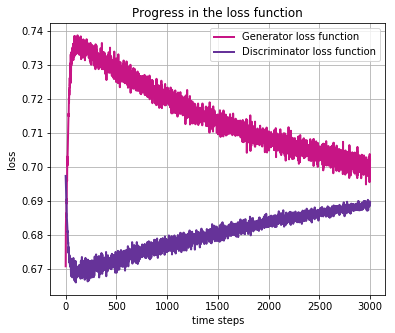

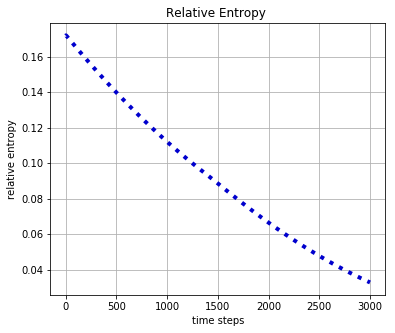

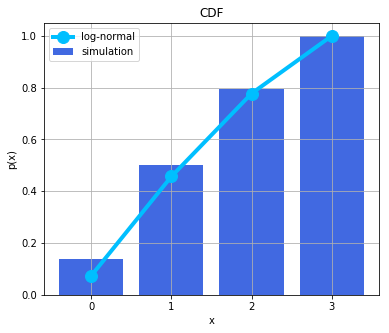

In [5]:
# Plot progress w.r.t the generator's and the discriminator's loss function
t_steps = np.arange(num_epochs)
plt.figure(figsize=(6,5))
plt.title("Progress in the loss function")
plt.plot(t_steps, qgan.g_loss, label = "Generator loss function", color = 'mediumvioletred', linewidth = 2)
plt.plot(t_steps, qgan.d_loss, label = "Discriminator loss function", color = 'rebeccapurple', linewidth = 2)
plt.grid()
plt.legend(loc = 'best')
plt.xlabel('time steps')
plt.ylabel('loss')
plt.show()


# Plot progress w.r.t relative entropy
plt.figure(figsize=(6,5))
plt.title("Relative Entropy ")
plt.plot(np.linspace(0, num_epochs, len(qgan.rel_entr)), qgan.rel_entr, color ='mediumblue', lw=4, ls=':')
plt.grid()
plt.xlabel('time steps')
plt.ylabel('relative entropy')
plt.show()

#Plot the PDF of the resulting distribution against the target distribution, i.e. log-normal
log_normal = np.random.lognormal(mean=1, sigma=1, size=100000)
log_normal = np.round(log_normal)
log_normal = log_normal[log_normal <= bounds[1]]
temp = []
for i in range(int(bounds[1]+1)):
    temp += [np.sum(log_normal==i)]
log_normal = np.array(temp / sum(temp))

plt.figure(figsize=(6,5))
plt.title("CDF")
samples_g, prob_g = qgan.generator.get_samples(qgan.quantum_instance, shots=10000)
samples_g = np.array(samples_g)
samples_g = samples_g.flatten()
num_bins = len(prob_g)
plt.bar(samples_g,  np.cumsum(prob_g), color='royalblue', width= 0.8, label='simulation')
plt.plot( np.cumsum(log_normal),'-o', label='log-normal', color='deepskyblue', linewidth=4, markersize=12)
plt.xticks(np.arange(min(samples_g), max(samples_g)+1, 1.0))
plt.grid()
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend(loc='best')
plt.show()